In [32]:
import os, random, time
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch

from baseline_pipeline import extract_baseline_features
from ai_pipeline import ResNet18Embedder
from pipeline_utils import *

# Configuration
ROOT_DIR = "../fashion-dataset"
GROUPED_DIR = os.path.join(ROOT_DIR, "preprocessed_data")  

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Dataset Loading & Visualization

In [33]:
# Load items from the grouped directory
def load_items(grouped_dir):
    items = []
    for style_name in os.listdir(grouped_dir):
        style_path = os.path.join(grouped_dir, style_name)
        if not os.path.isdir(style_path):
            continue
        for fname in os.listdir(style_path):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(style_path, fname)
            items.append({
                "path": img_path,
                "style": style_name,
                "id": os.path.splitext(fname)[0],
            })
    return items

# Load and analyze dataset
items = load_items(GROUPED_DIR)
print("총 이미지 개수:", len(items))

# Distribution of styles
style_counts = Counter([it["style"] for it in items])
print("스타일 카테고리 수:", len(style_counts))
print("스타일당 평균 이미지 수:", np.mean(list(style_counts.values())))
print("스타일당 최소/최대:", min(style_counts.values()), max(style_counts.values()))


총 이미지 개수: 6217
스타일 카테고리 수: 697
스타일당 평균 이미지 수: 8.919655667144907
스타일당 최소/최대: 4 20


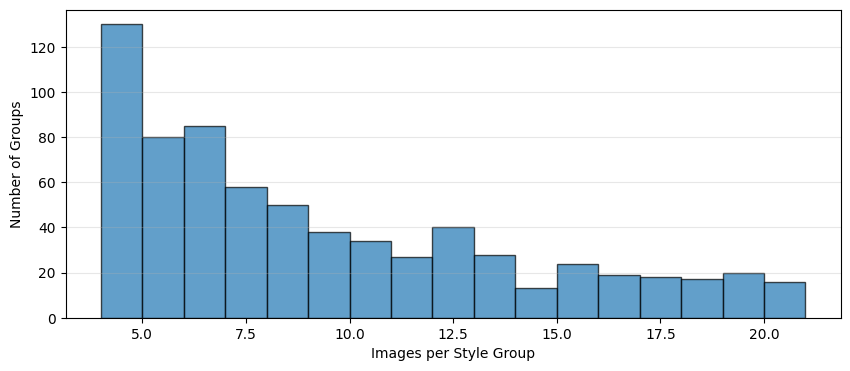

In [34]:
# Plot distribution of images per style group
counts = np.array(list(style_counts.values()))
plt.figure(figsize=(10,4))
plt.hist(counts, bins=range(counts.min(), counts.max()+2), edgecolor='black', alpha=0.7)
plt.xlabel("Images per Style Group")
plt.ylabel("Number of Groups")
plt.grid(axis="y", alpha=0.3)
plt.show()

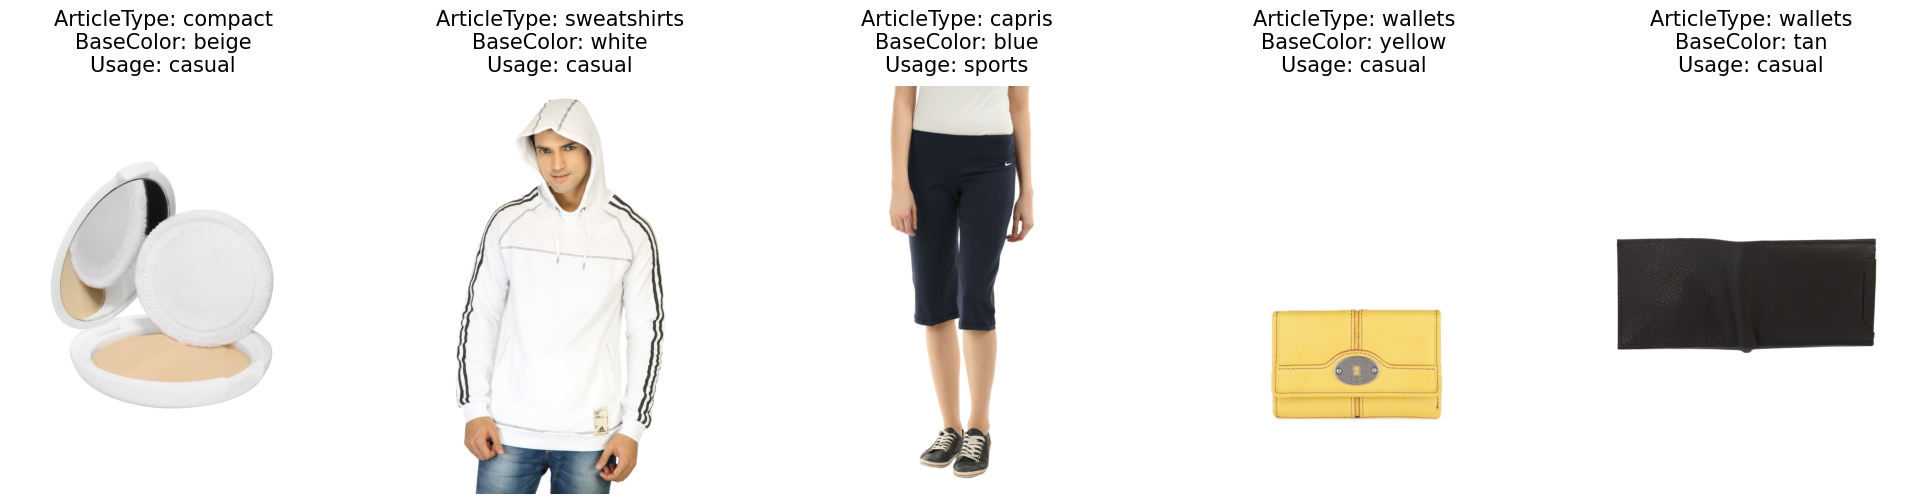

In [35]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Style folder name parsing
def parse_style_folder_name(folder_name: str):
    parts = folder_name.split("_")
    if len(parts) < 3:
        return folder_name, "unknown", "unknown"
    usage = parts[-1]
    base_color = parts[-2]
    article_type = "_".join(parts[:-2])
    return article_type, base_color, usage

# Pick a random image from the dataset folder
def pick_random_image_from_folder(folder_path: str):
    img_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".webp"))
    ]
    if not img_files:
        return None
    fname = random.choice(img_files)
    return os.path.join(folder_path, fname)

# Visualize 5 random images from distinct style group folders
def visualize_random_images(preprocess_dir: str, n=5, seed=42):
    random.seed(seed)

    # Style group folder list
    folders = [
        d for d in os.listdir(preprocess_dir)
        if os.path.isdir(os.path.join(preprocess_dir, d))
    ]
    if not folders:
        print("No style-group folders found.")
        return

    # Sample folders to pick images from distinct style groups
    chosen_folders = random.sample(folders, k=min(n, len(folders)))

    # Visualization
    plt.figure(figsize=(4*n, 5))

    for i, folder_name in enumerate(chosen_folders):
        folder_path = os.path.join(preprocess_dir, folder_name)
        img_path = pick_random_image_from_folder(folder_path)
        if img_path is None:
            continue

        img = Image.open(img_path).convert("RGB")

        article_type, base_color, usage = parse_style_folder_name(folder_name)

        ax = plt.subplot(1, n, i + 1)
        ax.imshow(img)
        ax.axis("off")

        caption = f"ArticleType: {article_type}\nBaseColor: {base_color}\nUsage: {usage}"
        ax.set_title(caption, fontsize=15, pad=10)

    plt.tight_layout()
    plt.show()

PREPROCESS_DIR = "../fashion-dataset/preprocessed_data"
visualize_random_images(PREPROCESS_DIR, n=5, seed=42)


### Extract Image Features from Baseline & AI Pipeline Methods

In [37]:
CACHE_DIR = "./cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Number of nearest neighbors to retrieve
K = 5

# Directory for cached features for faster experimentation
baseline_cache = os.path.join(CACHE_DIR, "baseline_feats.npy")
resnet_cache = os.path.join(CACHE_DIR, "resnet18_feats.npy")

# Baseline features
if os.path.exists(baseline_cache):
    baseline_feats = np.load(baseline_cache)
    print("Loaded baseline feats:", baseline_feats.shape)
else:
    t0 = time.time()
    baseline_feats = extract_baseline_features(items)
    np.save(baseline_cache, baseline_feats)
    print("Saved baseline feats:", baseline_feats.shape, "Time:", time.time()-t0)

# ResNet features
embedder = ResNet18Embedder(device=device)

if os.path.exists(resnet_cache):
    resnet_feats = np.load(resnet_cache)
    print("Loaded resnet feats:", resnet_feats.shape)
else:
    t0 = time.time()
    resnet_feats = embedder.extract_features(items)
    np.save(resnet_cache, resnet_feats)
    print("Saved resnet feats:", resnet_feats.shape, "Time:", time.time()-t0)


Loaded baseline feats: (6217, 512)
Loaded resnet feats: (6217, 512)


### Retrieval Results

In [ ]:
# top-k indices
t0 = time.time()
baseline_topk_idx = cosine_topk_indices(baseline_feats, k=K)
print("Baseline topk computed in", time.time()-t0, "sec")

t0 = time.time()
resnet_topk_idx = cosine_topk_indices(resnet_feats, k=K)
print("ResNet topk computed in", time.time()-t0, "sec")

# metrics
baseline_metrics = evaluate_retrieval_from_topk(baseline_topk_idx, items, k=K)
resnet_metrics   = evaluate_retrieval_from_topk(resnet_topk_idx, items, k=K)

print(f"\n===== Retrieval Results (K={K}) =====")
print("[Baseline - Color Histogram]")
for kk, vv in baseline_metrics.items():
    if kk == "per_query": 
        continue
    print(f"  {kk}: {vv:.4f}" if isinstance(vv, float) else f"  {kk}: {vv}")

print("\n[AI Pipeline - ResNet-18]")
for kk, vv in resnet_metrics.items():
    if kk == "per_query": 
        continue
    print(f"  {kk}: {vv:.4f}" if isinstance(vv, float) else f"  {kk}: {vv}")

Baseline topk computed in 3.3871572017669678 sec
ResNet topk computed in 2.9028735160827637 sec

===== Retrieval Results (K=5) =====
[Baseline - Color Histogram]
  P@5: 0.0993
  R@5: 0.0516
  Hit@5: 0.3305
  num_queries: 6217

[AI Pipeline - ResNet-18]
  P@5: 0.2154
  R@5: 0.1175
  Hit@5: 0.5993
  num_queries: 6217


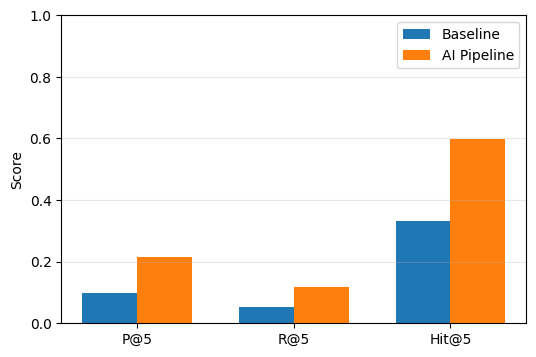

In [38]:
# Visualization of comparison
def compare_bar_plot(baseline_metrics, ai_metrics, k=5):
    labels = [f"P@{k}", f"R@{k}", f"Hit@{k}"]
    b = [baseline_metrics[l] for l in labels]
    a = [ai_metrics[l] for l in labels]

    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, b, width, label="Baseline")
    plt.bar(x + width/2, a, width, label="AI Pipeline")
    plt.xticks(x, labels)
    plt.ylim(0, 1.0)
    plt.ylabel("Score")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

compare_bar_plot(baseline_metrics, resnet_metrics, k=K)


### Analyze Results

In [ ]:
# Per-query analysis
def per_query_hits_from_topk(topk, items):
    # Ground-truth style groups
    style = [it["style"] for it in items]
    style_to_idx = defaultdict(list)
    for i, s in enumerate(style):
        style_to_idx[s].append(i)

    hits = []
    gt_sizes = []
    for i in range(len(items)):
        gt = [j for j in style_to_idx[style[i]] if j != i]
        if len(gt) == 0:
            hits.append(None)
            gt_sizes.append(0)
            continue
        hit_cnt = len(set(topk[i].tolist()) & set(gt))
        hits.append(hit_cnt)   
        gt_sizes.append(len(gt))
    return np.array(hits, dtype=object), np.array(gt_sizes)

b_hitcnt, gt_sizes = per_query_hits_from_topk(baseline_topk_idx, items)
a_hitcnt, _ = per_query_hits_from_topk(resnet_topk_idx, items)

# Valid queries
valid = np.array([x is not None for x in b_hitcnt])
valid_idx = np.where(valid)[0]

# Analyze success/failure cases
both_fail = [i for i in valid_idx if (b_hitcnt[i]==0 and a_hitcnt[i]==0)]
b_only = [i for i in valid_idx if (b_hitcnt[i]>0 and a_hitcnt[i]==0)]
a_only = [i for i in valid_idx if (b_hitcnt[i]==0 and a_hitcnt[i]>0)]

print("Both fail:", len(both_fail))
print("Baseline only success:", len(b_only))
print("ResNet only success:", len(a_only))


Both fail: 2070
Baseline only success: 421
ResNet only success: 2092


In [45]:
# Visualization function for retrieval cases
def show_retrieval_case(
    query_idx, baseline_topk, resnet_topk, items,
    k=5, title="", style="fancy"
):
    q = items[query_idx]
    q_img = Image.open(q["path"]).convert("RGB")

    fig = plt.figure(figsize=(2.2*(k+1), 6))
    plt.suptitle(title, fontsize=13, fontweight="bold")

    fig.subplots_adjust(left=0.12)

    # Baseline & AI Pipeline label
    fig.text(0.005, 0.75, "Baseline", rotation="vertical",
            va="center", ha="center", fontsize=12, fontweight="bold")
    fig.text(0.005, 0.25, "AI Pipeline", rotation="vertical",
            va="center", ha="center", fontsize=12, fontweight="bold")
    
    # Helper to set visual styles
    def set_visual(ax, correct, prefix, rank, style):
        if correct:
            label = "Match" if style == "match" else f"{prefix}#{rank} ✓"
            color = "green"
        else:
            label = "Mismatch" if style == "match" else f"{prefix}#{rank} ✗"
            color = "red"

        ax.set_title(label, color=color, fontsize=10)

        if style == "fancy":
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)

    # Row 1: Baseline
    ax = plt.subplot(2, k+1, 1)
    ax.imshow(q_img)
    ax.set_title(q['style'], fontsize=10)
    ax.axis("off")

    for r in range(k):
        idx = int(baseline_topk[query_idx][r])
        it = items[idx]
        img = Image.open(it["path"]).convert("RGB")

        ax = plt.subplot(2, k+1, r+2)
        ax.imshow(img)
        correct = (it["style"] == q["style"])
        set_visual(ax, correct, "Baseline", r+1, style)
        ax.axis("off")

    # Row 2: ResNet
    ax = plt.subplot(2, k+1, (k+1)+1)
    ax.imshow(q_img)
    ax.set_title(q['style'], fontsize=10)
    ax.axis("off")

    for r in range(k):
        idx = int(resnet_topk[query_idx][r])
        it = items[idx]
        img = Image.open(it["path"]).convert("RGB")

        ax = plt.subplot(2, k+1, (k+1)+(r+2))
        ax.imshow(img)
        correct = (it["style"] == q["style"])
        set_visual(ax, correct, "AI", r+1, style)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


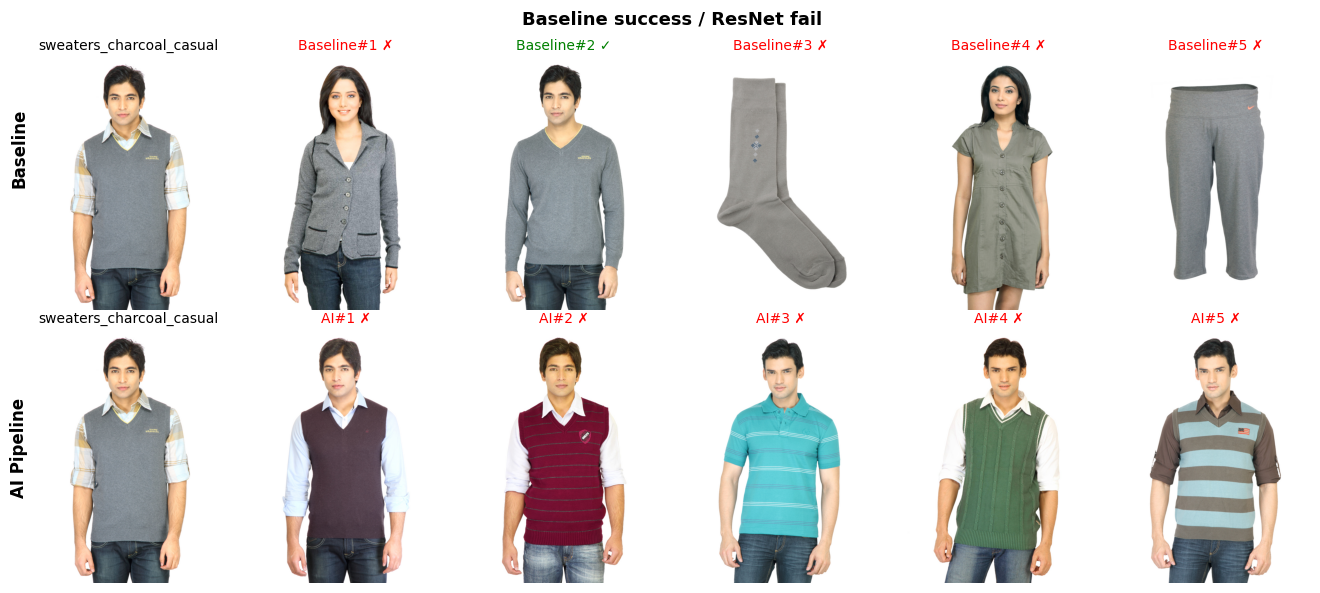

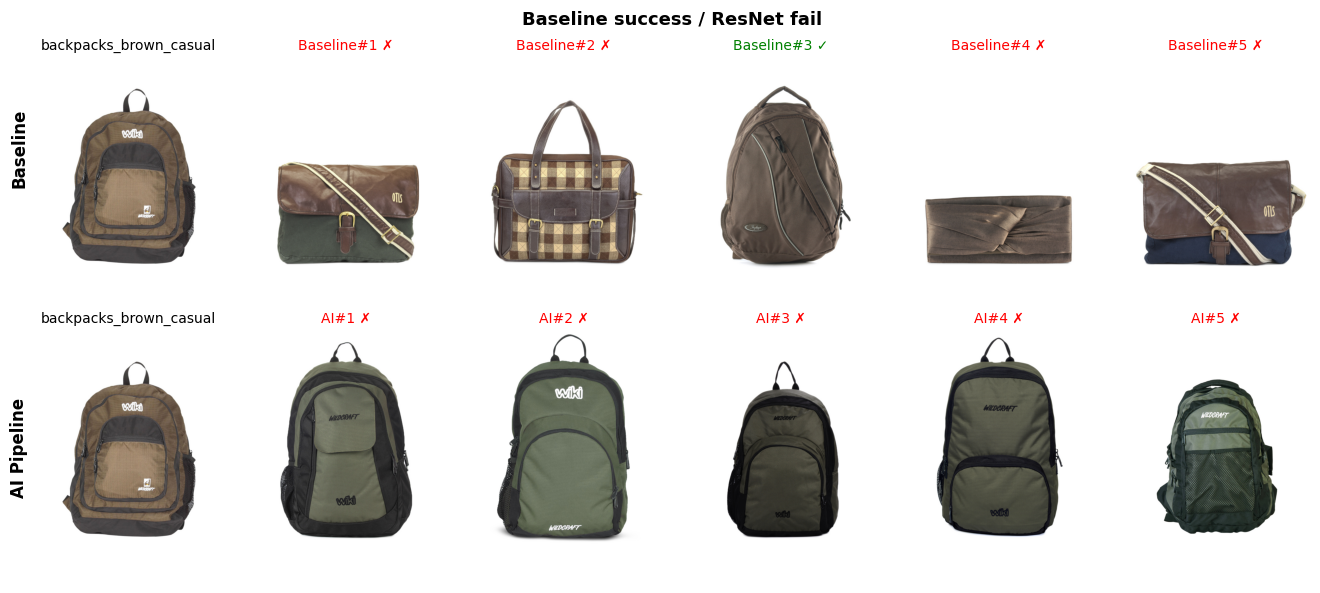

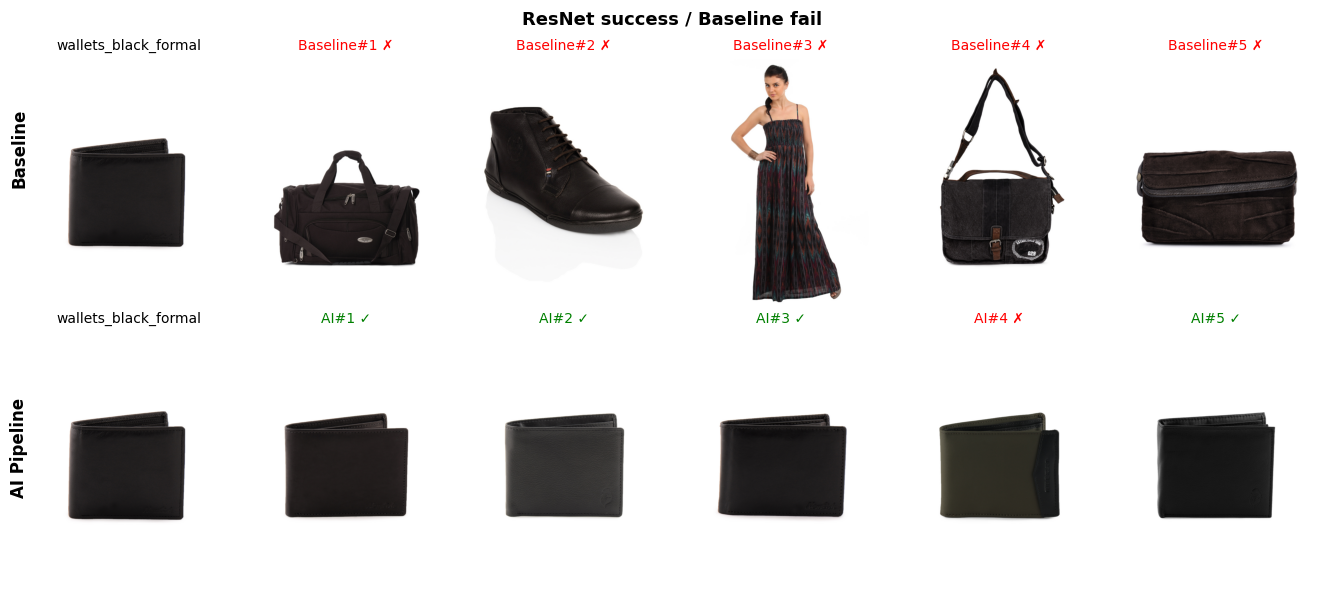

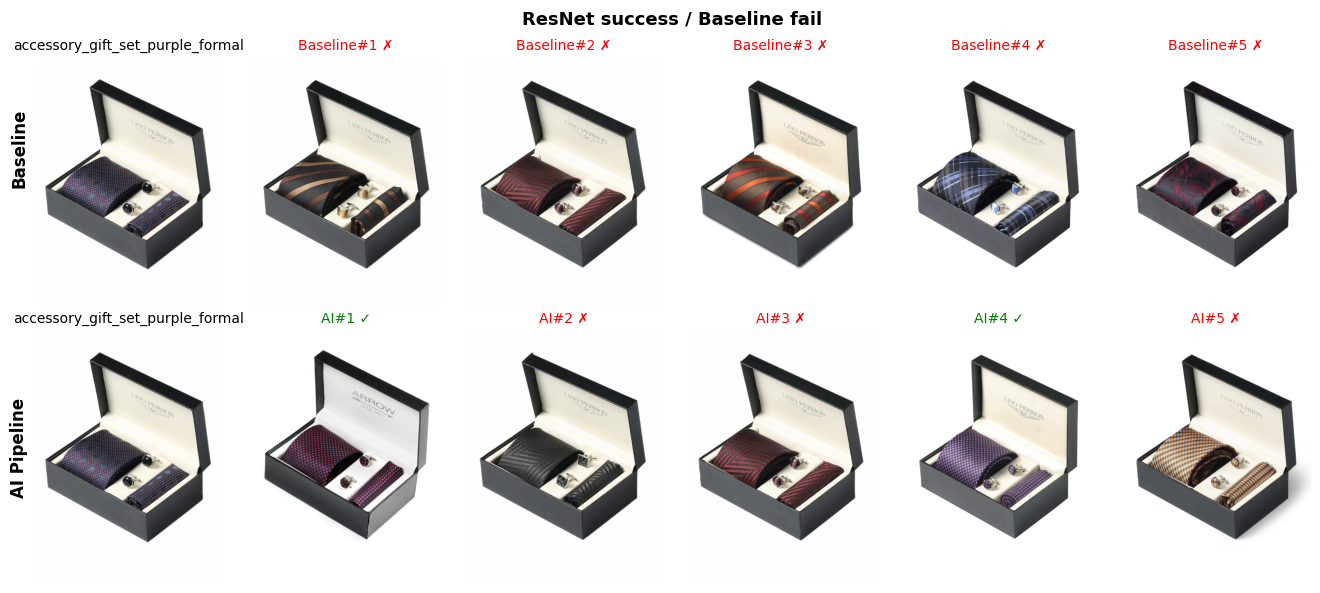

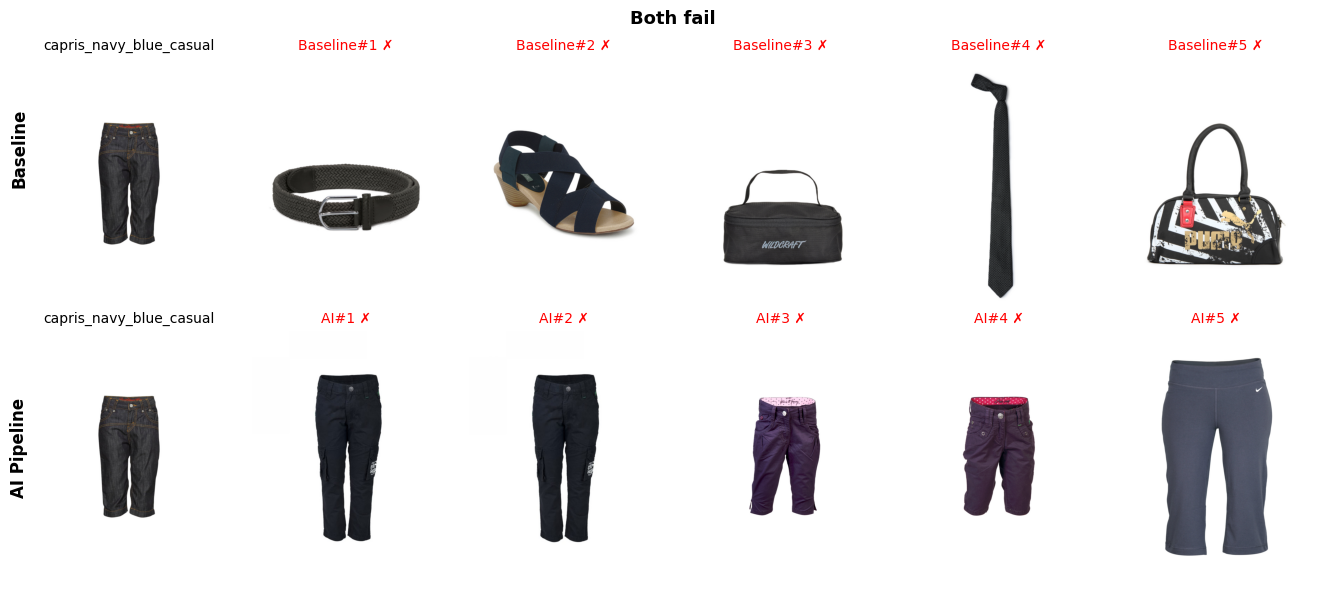

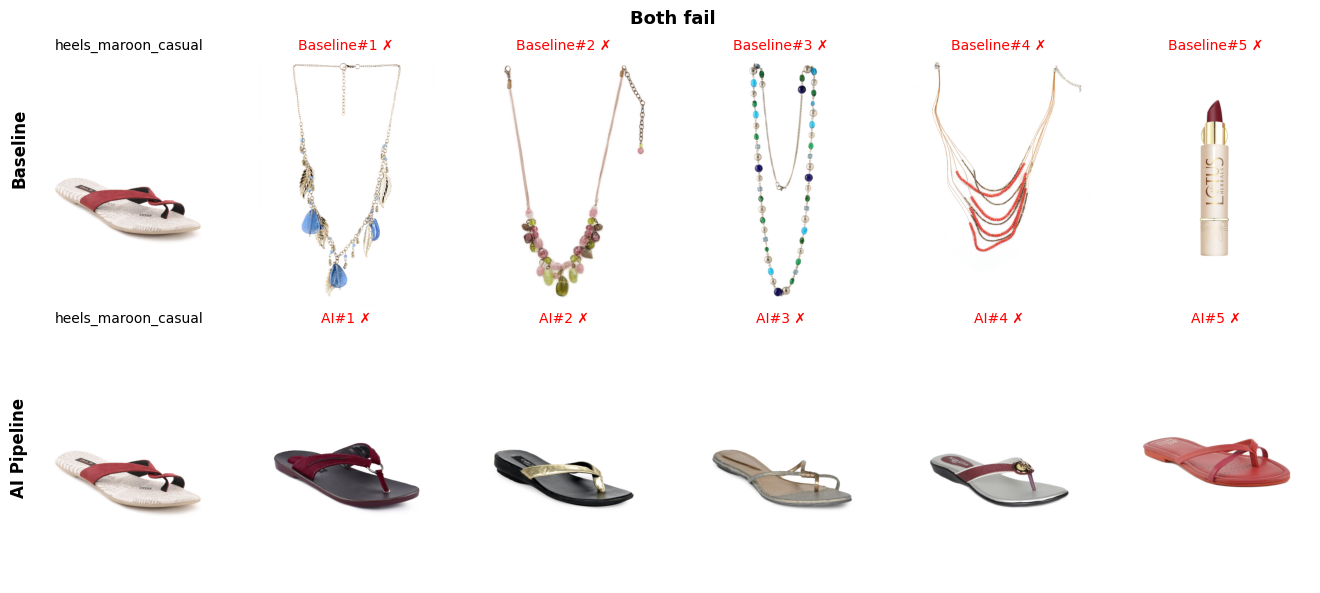

In [46]:
# Sample and show cases
def sample_and_show_compact(candidates, name, n=1):
    if len(candidates) == 0:
        print(f"[{name}] no samples")
        return
    # Random sampling
    picks = random.sample(candidates, k=min(n, len(candidates)))
    # Show cases
    for qi in picks:
        show_retrieval_case(
            qi, baseline_topk_idx, resnet_topk_idx, items, k=K,
            title=name
        )

sample_and_show_compact(b_only, "Baseline success / ResNet fail", n=2)
sample_and_show_compact(a_only, "ResNet success / Baseline fail", n=2)
sample_and_show_compact(both_fail, "Both fail", n=2)